# <center> Pandemic Watching

In [1]:
#importing Libraries

import pandas as pd
import matplotlib.pyplot as plt
import requests
import json
from pprint import pprint
import numpy as np
import scipy.stats as st
from config import m_api_key
from config import t_api_key

In [2]:
# Creating Dataframe of Netflix Movies  ( based out of www.flixable.com)
df = pd.read_csv('flixable_df.csv')
df.head()

,Unnamed: 0,date,link,title,description,href,rating
0,0,January 29,https://flixable.com/title/below-zero/,Below Zero,2021,https://www.imdb.com/title/tt4016994/?ref_=tt_...,7.5/10
1,1,January 29,https://flixable.com/title/finding-ohana/,Finding ‘Ohana,2021,https://www.imdb.com/title/tt10332588/?ref_=tt...,6.1/10
2,2,January 29,https://flixable.com/title/the-dig/,The Dig,2021,https://www.imdb.com/title/tt3661210/?ref_=tt_...,7.2/10
3,3,January 29,https://flixable.com/title/we-are-the-brooklyn...,We Are: The Brooklyn...,2021,https://www.imdb.com/title/tt3661210/?ref_=tt_...,7.2/10
4,4,January 28,https://flixable.com/title/june-kopi/,June & Kopi,2021,https://www.imdb.com/title/tt13728764/?ref_=tt...,6.8/10


In [ ]:
# number of release per month

In [ ]:
# talk about the comparison between 2019 vs 2020

In [45]:
#extracting list of movies released in 2019 and 2020 
movie19 = df.loc[df['description']==2019,'title']
movie20 = df.loc[df['description']==2020,'title']
print(f'Total number of movies in 2019 are {len(movie19)}')
print(f'Total number of movies in 2020 are {len(movie20)}')


Total number of movies in 2019 are 972
Total number of movies in 2020 are 877


### Creating functions 

In [46]:
def movie_id(movie_list):
    tmdb_df = pd.read_json('movie_ids_02_01_2021.json',lines = True)
    tmdb_df.rename(columns = {'original_title': 'title'},inplace = True)
    tmdb_df.set_index('title')
    id_df = pd.merge(tmdb_df, movie_list, how='inner', on = 'title')
    imdb_id = []
    name = []
    revenue = []
    c= 0
    for ids in id_df['id']:
        try:
            
            target_url = f'https://api.themoviedb.org/3/movie/{ids}?api_key={t_api_key}'
            response = requests.get(target_url)
            data = response.json()
    #         pprint(data)
            imdb_id.append(data['imdb_id'])
            name.append(data['title'])
            revenue.append(data['revenue'])
            print(f'Revenue found for tmdb id {ids}')
            c+=1
        except:
            print(f'No revenue data found for tmdb id {ids} ')

    revenue_df  = pd.DataFrame({'Title': name, 'MovieID': imdb_id, 'revenue':revenue})
    print(f'----------------------------------------------------------------------------\n Revenue Data extracted successfully for {c} movies\n----------------------------------------------------------------------------')
    return (revenue_df)
            


def fetch_db (movies):
    title = []
    genre = []
    lang = []
    idx = []
    irating = []
    ivotes = []
    year = []
    count = 0
    print('--------------------------------------\nExtracting Data from OMDB\n--------------------------------------')
    for each_movie in movies:
        url = f"http://www.omdbapi.com/?t={each_movie}&apikey={m_api_key}" 
#         print(url)
        try:

            response = requests.get(url)
            data = response.json()
            title.append(data['Title'])
            ivotes.append(data['imdbVotes'])
            irating.append(data['imdbRating'])
            idx.append(data['imdbID'])
            genre.append(data['Genre'].split(','))
            print(f'Movie: {each_movie} check')
        except:
            print(f'Movie: {each_movie}  details not found')
            count+=1
   
    movie_df = pd.DataFrame({'MovieID':idx, 'Title': title, 'Votes':ivotes, 'Rating': irating, 'Genre': genre})
    print(f'--------------------------------------\nTotal Movies in the Database  :  {len(movie_df)}      \n--------------------------------------\nTotal Missing Movies  :  {count}      \n--------------------------------------')

    return(movie_df)


def outlier(df,col):
    q1 = np.quantile(df[col],0.25) 
    q3 = np.quantile(df[col],0.75)
    IQR = q3 - q1
    upbound = q3+(1.5* IQR)
    lowbound = q1-(1.5*IQR)
    fig1, ax1 = plt.subplots()
    ax1.boxplot(df[col],  sym = 'r', showmeans = True)
    plt.show()   

    #dropping the outliers
    for idx, srs in df.iterrows():
        if srs[col]<lowbound:
            df = df.drop(index = idx)
        if srs[col]>upbound:
            df = df.drop(index = idx)
    plt.show() 
    print(f'---------------------- After dropping Outliers----------------------')
    print(f'-----------------------Final Data Points = {len(df)}----------------------')
    df.hist()
    plt.show() 
    

def regress(x,y,nx,ny):
    slope, inter, r, p, std = st.linregress(x,y)
    x_axis_19 = np.arange(max(x))
    y_pred_19 = slope*x_axis_19 +inter
    plt.plot(x_axis_19,y_pred_19, c='r')
    print(f'r is {r} and p is {p}')
    plt.annotate(f'y = {round(slope,4)}x + {round(inter,2)} ', (nx,ny), c= 'r',fontsize = 10)
    plt.show()
    
def rating_votes(df, gen1):
    v_count=0
    r_count=0
    rev_count = 0
    new_r_gen = []
    new_r_gen = gen1
    new_r_gen
    for genre in gen1['Genre']:
        for idx , srs in df.iterrows():
            for g in srs['Genre']:
                if g == genre:
                    v_count+=srs['Votes']/100000
                    r_count+=srs['Rating']
        new_r_gen.loc[new_r_gen['Genre'] == genre,'Votes']=v_count
        new_r_gen.loc[new_r_gen['Genre'] == genre,'Rating']= r_count
        
        v_count=0
        r_count=0
    return(new_r_gen)
        
    
    
    
    
def genre_revenue(df,gen2):
    rev_count = 0
    for genre in gen2['Genre']:
        for idx , srs in df.iterrows():
            for g in srs['Genre']:
                if g == genre:
                    rev_count +=float(srs['revenue'])
        gen2.loc[gen2['Genre']==genre,'revenue']= rev_count/1000000
        rev_count = 0
    return(gen2)

# Generate some fake data to test with
# def gendata(loc1=0, loc2=0):
   
#     # Scatter Plot of Data
#     plt.subplot(2, 1, 1)
#     plt.scatter(range(len(population1)), population1, label="population1")
#     plt.scatter(range(len(population2)), population2, label="population2")
#     plt.legend()

#     # Histogram Plot of Data
#     plt.subplot(2, 1, 2)
#     plt.hist(population1, 10, density=True, alpha=0.7, label="population1")
#     plt.hist(population2, 10, density=True, alpha=0.7, label="population2")
#     plt.axvline(population1.mean(), color='k', linestyle='dashed', linewidth=1)
#     plt.axvline(population2.mean(), color='k', linestyle='dashed', linewidth=1)
#     plt.legend()  
    
#     return population1, population2


# 2019 movies Database

In [137]:
#calling all the 2019 movies on Netflix by pinging the OMDB API
movie19_df = fetch_db(movie19)

--------------------------------------
Extracting Data from OMDB
--------------------------------------
Movie: Hire a Woman check
Movie: She Is check
Movie: Demon Slayer: Kimetsu... check
Movie: Pinkfong & Baby Shark's... check
Movie: Al acecho check
Movie: L.A.’s Finest  details not found
Movie: QB1: Beyond the Lights check
Movie: The Creative Brain check
Movie: Too Handsome to Handle  details not found
Movie: Dare Me check
Movie: Sakho & Mangane check
Movie: Isa Pa with Feelings check
Movie: Bridezilla check
Movie: Hello, Love, Goodbye check
Movie: Mohamed Hussein  details not found
Movie: Diamond City check
Movie: Jeopardy! check
Movie: Eggnoid: Love & Time... check
Movie: Sakaling Maging Tayo check
Movie: The Wedding Shaman  details not found
Movie: The Professor and the... check
Movie: The Panti Sisters check
Movie: Kalel, 15 check
Movie: Once Upon a Time check
Movie: Juman check
Movie: Between Maybes check
Movie: Rust Creek check
Movie: Spookley and the... check
Movie: 40 Sticks 

Movie: A Sun check
Movie: Playing with Fire check
Movie: KD (A) Karuppudurai check
Movie: Motichoor Chaknachoor check
Movie: Tiny House Nation check
Movie: Booba check
Movie: Deadcon check
Movie: Jezebel check
Movie: NiNoKuni check
Movie: Eye For An Eye check
Movie: The Brave check
Movie: Women of Mafia 2 check
Movie: Made in China check
Movie: Giri / Haji check
Movie: Anne with an E check
Movie: Thieves of the Wood check
Movie: Chhota Bheem Kung Fu... check
Movie: Luccas Neto in...  details not found
Movie: Aaviri check
Movie: Albert Pinto Ko Gussa... check
Movie: ARASHI's Diary -Voyage- check
Movie: Benchwarmers 2... check
Movie: Good Girls check
Movie: How High 2 check
Movie: Occupied check
Movie: The Degenerates check
Movie: The Neighbor check
Movie: Yanxi Palace: Princess... check
Movie: The Disastrous Life of... check
Movie: Hot Gimmick: Girl Meets... check
Movie: Kevin Hart: Don’t F**k...  details not found
Movie: The Secret Life of Pets 2 check
Movie: The App check
Movie: The B

Movie: Rhythm + Flow check
Movie: Deon Cole: Cole Hearted check
Movie: The Spooky Tale of... check
Movie: Legend Quest: Masters... check
Movie: My Country: The New Age check
Movie: Noblemen check
Movie: Brother in Love check
Movie: Creeped Out check
Movie: In the Tall Grass check
Movie: Kids on the Block check
Movie: Peaky Blinders check
Movie: Raising Dion check
Movie: Rotten check
Movie: Super Monsters check
Movie: Super Monsters: Vida's... check
Movie: Seis Manos check
Movie: Living Undocumented check
Movie: Ready to Mingle check
Movie: Little Baby Bum: Go Buster  details not found
Movie: Nikki Glaser: Bangin’ check
Movie: Gotham check
Movie: Mo Gilligan: Momentum check
Movie: Cultivating the Seas...  details not found
Movie: Domino check
Movie: TUNA GIRL check
Movie: Bard of Blood check
Movie: El Marginal check
Movie: In the Shadow of the Moon check
Movie: Skylines check
Movie: Sturgill Simpson... check
Movie: Explained check
Movie: Malaal check
Movie: Abstract: The Art of... check

Movie: Pegasus check
Movie: When They See Us check
Movie: Svaha: The Sixth Finger check
Movie: Historical Roasts check
Movie: After Maria check
Movie: Joy check
Movie: Rim of the World check
Movie: The Perfection check
Movie: WHAT / IF check
Movie: The Lonely Island... check
Movie: A Tale of Two Kitchens check
Movie: Wanda Sykes: Not Normal check
Movie: Prince of Peoria check
Movie: 1994 check
Movie: It's Bruno! check
Movie: Maria check
Movie: ReMastered: The Lion's... check
Movie: Saverio Raimondo: Il... check
Movie: See You Yesterday check
Movie: White Gold check
Movie: Good Sam check
Movie: PATRICK (2019)  details not found
Movie: I Hear You check
Movie: Backdraft 2 check
Movie: Still LAUGH-IN: The... check
Movie: Malibu Rescue check
Movie: The Defected check
Movie: Shéhérazade check
Movie: Easy check
Movie: Jailbirds check
Movie: The Mechanism check
Movie: The Society check
Movie: Wine Country check
Movie: Abyss check
Movie: I Have a Script  details not found
Movie: In the Bosom of

In [138]:
revenue19_df = movie_id(movie19)

Revenue found for tmdb id 187
Revenue found for tmdb id 742121
Revenue found for tmdb id 327
Revenue found for tmdb id 173274
Revenue found for tmdb id 356501
Revenue found for tmdb id 524114
Revenue found for tmdb id 681960
Revenue found for tmdb id 720122
Revenue found for tmdb id 754869
Revenue found for tmdb id 441
Revenue found for tmdb id 300972
Revenue found for tmdb id 576692
Revenue found for tmdb id 624841
Revenue found for tmdb id 797
Revenue found for tmdb id 659481
Revenue found for tmdb id 667999
Revenue found for tmdb id 675776
Revenue found for tmdb id 741572
Revenue found for tmdb id 1976
Revenue found for tmdb id 576704
Revenue found for tmdb id 688034
Revenue found for tmdb id 2157
Revenue found for tmdb id 577902
Revenue found for tmdb id 620244
Revenue found for tmdb id 2291
Revenue found for tmdb id 456529
Revenue found for tmdb id 457394
Revenue found for tmdb id 3113
Revenue found for tmdb id 170173
Revenue found for tmdb id 518671
Revenue found for tmdb id 4232

Revenue found for tmdb id 494379
Revenue found for tmdb id 495511
Revenue found for tmdb id 557307
Revenue found for tmdb id 557372
Revenue found for tmdb id 663191
Revenue found for tmdb id 670752
Revenue found for tmdb id 674801
Revenue found for tmdb id 689255
Revenue found for tmdb id 690814
Revenue found for tmdb id 715367
Revenue found for tmdb id 742691
Revenue found for tmdb id 759649
Revenue found for tmdb id 38920
Revenue found for tmdb id 107781
Revenue found for tmdb id 168534
Revenue found for tmdb id 706305
Revenue found for tmdb id 39172
Revenue found for tmdb id 117705
Revenue found for tmdb id 118612
Revenue found for tmdb id 163733
Revenue found for tmdb id 273488
Revenue found for tmdb id 300504
Revenue found for tmdb id 423904
Revenue found for tmdb id 520185
Revenue found for tmdb id 537915
Revenue found for tmdb id 650657
Revenue found for tmdb id 41266
Revenue found for tmdb id 47945
Revenue found for tmdb id 49437
Revenue found for tmdb id 183292
Revenue found f

Revenue found for tmdb id 567706
Revenue found for tmdb id 589362
Revenue found for tmdb id 644409
Revenue found for tmdb id 654042
Revenue found for tmdb id 709429
Revenue found for tmdb id 764199
Revenue found for tmdb id 108256
Revenue found for tmdb id 602609
Revenue found for tmdb id 109841
Revenue found for tmdb id 478258
Revenue found for tmdb id 112205
Revenue found for tmdb id 231384
Revenue found for tmdb id 403693
Revenue found for tmdb id 406561
Revenue found for tmdb id 444500
Revenue found for tmdb id 602766
Revenue found for tmdb id 114750
Revenue found for tmdb id 135094
Revenue found for tmdb id 148824
Revenue found for tmdb id 148857
Revenue found for tmdb id 215497
Revenue found for tmdb id 460321
Revenue found for tmdb id 604824
Revenue found for tmdb id 636967
Revenue found for tmdb id 160808
Revenue found for tmdb id 472052
Revenue found for tmdb id 179587
Revenue found for tmdb id 572152
Revenue found for tmdb id 778681
Revenue found for tmdb id 179614
Revenue fo

Revenue found for tmdb id 743770
Revenue found for tmdb id 500682
Revenue found for tmdb id 519129
Revenue found for tmdb id 504859
Revenue found for tmdb id 567392
Revenue found for tmdb id 505929
Revenue found for tmdb id 505948
Revenue found for tmdb id 508965
Revenue found for tmdb id 509865
Revenue found for tmdb id 509967
Revenue found for tmdb id 510498
Revenue found for tmdb id 512959
Revenue found for tmdb id 513083
Revenue found for tmdb id 513409
Revenue found for tmdb id 514999
Revenue found for tmdb id 515248
Revenue found for tmdb id 515743
Revenue found for tmdb id 519674
Revenue found for tmdb id 520901
Revenue found for tmdb id 523139
Revenue found for tmdb id 525183
Revenue found for tmdb id 525235
Revenue found for tmdb id 528493
Revenue found for tmdb id 528888
Revenue found for tmdb id 528985
Revenue found for tmdb id 789986
Revenue found for tmdb id 529962
Revenue found for tmdb id 531033
Revenue found for tmdb id 531306
Revenue found for tmdb id 531438
Revenue fo

In [140]:
revenue19_df

,Title,MovieID,revenue
0,Sin City,tt0401792,158733820
1,Sin City,None,0
2,Brother,tt0222851,15250000
3,Brother,tt0245024,0
4,Brother,,0
...,...,...,...
970,Zulu Man in Japan,None,0
971,One Day at a Time,tt0675272,0
972,The Witcher,None,0
973,Chambers,None,0


In [259]:
#joining the revenue dataframe with the genre dataframe based on movie title and imdb ID
rev19_db = pd.merge(movie19_df,revenue19_df,how = 'inner', on = ['Title','MovieID'])
revenue_df.set_index('Title')
revenue_df.head(100)
# a small smaple of data is present which has information on revenue. But the sample size is suffiecient for representing the data
rev19_db = rev19_db[rev19_db['revenue']!=0]
print(len(rev19_db))


37


In [260]:
rev19_db.dtypes #ensuring the revenue is stored as a numeric

MovieID     object
Title       object
Votes      float64
Rating     float64
Genre       object
revenue      int64
dtype: object

In [261]:
movie19_db = movie19_df
# cleaning up the data
movie19_db['Votes'].replace(',','', regex=True, inplace=True)
movie19_db['Rating'].replace(',','', regex=True, inplace=True)
# remove commas from votes and ratings
movie19_db['Votes'] = movie19_db['Votes'].apply(pd.to_numeric, downcast='float', errors='coerce')
movie19_db['Rating'] = movie19_db['Rating'].apply(pd.to_numeric, downcast='float', errors='coerce')
# convert to float for numeric calculation

In [262]:
movie19_db.dtypes

MovieID     object
Title       object
Votes      float64
Rating     float64
Genre       object
dtype: object

In [263]:
#Dropping rows with null value
movie19_db.dropna(inplace=True)
len(movie19_db) # total value = 871

875

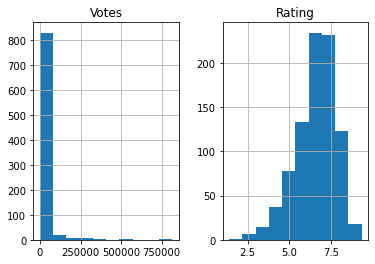

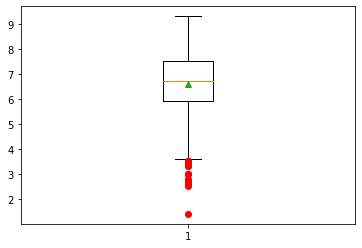

---------------------- After dropping Outliers----------------------
-----------------------Final Data Points = 858----------------------


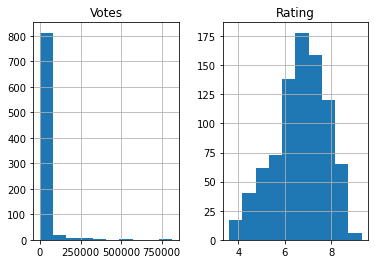

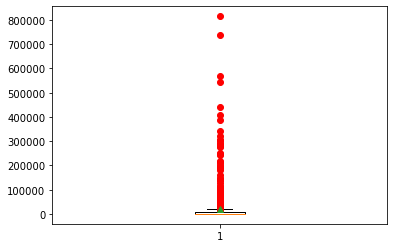

---------------------- After dropping Outliers----------------------
-----------------------Final Data Points = 749----------------------


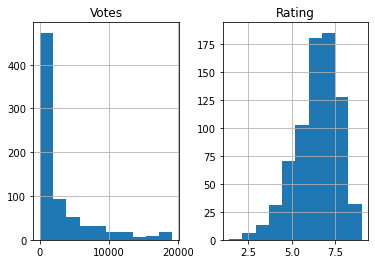

In [264]:
# understanding the Movie Ratings and Votes Data
#Shape of data
movie19_db.hist()

# Identifying and removing Outliers from Ratings
outlier(movie19_db, 'Rating')
outlier(movie19_db, 'Votes')
    
# movie ratings are now somewhat normally distributed   

In [265]:
new_genre = []
for i in movie19_db['Genre']:
    for j in i:
        new_genre.append(j.strip())
genre19_list = np.unique(new_genre)
genre19_list.sort()
genre19_list
genre19_df = pd.DataFrame({'Genre':genre19_list})
genre19_df
# row #17 list N/A as a Genre which needs to be removed
genre19_df = genre19_df.drop(index=17)
r_genre19_df = genre19_df.copy() #extra copy
genre19_df

,Genre
0,Action
1,Adventure
2,Animation
3,Biography
4,Comedy
5,Crime
6,Documentary
7,Drama
8,Family
9,Fantasy


In [266]:
rev19_db

,MovieID,Title,Votes,Rating,Genre,revenue
2,tt10156112,"Hello, Love, Goodbye",785.0,7.3,"[Drama, Romance]",16800000
4,tt10637682,The Panti Sisters,194.0,5.5,[Comedy],8727994
13,tt0219822,Human Nature,17465.0,6.4,"[Comedy, Drama]",1600000
15,tt0338526,Van Helsing,244301.0,6.1,"[Action, Adventure, Fantasy]",300257475
22,tt0401792,Sin City,737973.0,8.0,"[Crime, Thriller]",158733820
23,tt6852872,Elizabeth Harvest,6810.0,5.8,"[Horror, Sci-Fi, Thriller]",4973
37,tt6428150,High Strung Free Dance,1281.0,6.8,"[Music, Romance]",235066
38,tt5727208,Uncut Gems,218564.0,7.4,"[Crime, Drama, Thriller]",50020902
40,tt0077504,The End,3599.0,6.2,"[Comedy, Drama]",45000000
55,tt0089601,Mischief,5683.0,6.6,"[Comedy, Romance]",8692426


<AxesSubplot:xlabel='Genre'>

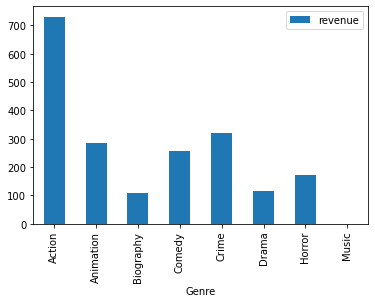

In [271]:
final19_rev_df = genre_revenue(rev19_db,genre19_df)
final19_rev_df
final19_rev_df.drop(index =(final19_rev_df.loc[final19_rev_df['revenue']==0,:]).index, inplace = True) # removing genres which did not have revenue details
final19_rev_df.plot('Genre','revenue',kind = 'bar')# revenue in millions

In [185]:
rating_votes(movie19_db, r_genre19_df)
r_genre19_df.drop(index =(r_genre19_df.loc[r_genre19_df['Votes']==0,:]).index, inplace = True)
r_genre19_df

,Genre,Votes,Rating
0,Action,34.83879,501.600001
1,Adventure,8.57826,137.800000
2,Animation,4.95420,583.599998
3,Biography,11.64008,153.600000
4,Comedy,26.07779,1305.700000
5,Crime,31.61791,444.199998
6,Documentary,3.58488,885.900004
7,Drama,33.91198,1113.000000
8,Family,0.03083,42.100000
9,Fantasy,0.01619,12.300000


<AxesSubplot:xlabel='Genre'>

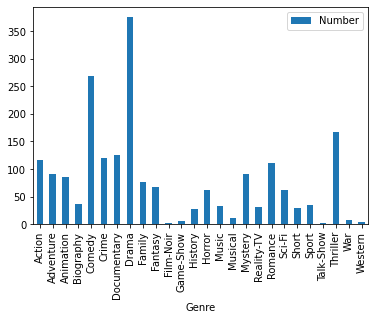

In [186]:
#identifying the number of movies in each genre
matrix = pd.get_dummies((movie19_db['Genre'].apply(pd.Series).stack()).str.strip()).sum(level = 0)
matrix.drop(columns = 'N/A', inplace = True)
total = pd.DataFrame(matrix.sum())
total['Genre']= total.index
total.set_index(np.arange(26))
total.rename(columns = {0: 'Number'}, inplace = True)
total.plot('Genre','Number', kind = 'bar')

### this plot shows that maximum number of movies were released in Drama Genre followed by comedy

,Genre,Votes,Rating,Number,AverageRating
0,Action,34.83879,501.600001,116,4.324138
1,Adventure,8.57826,137.800000,90,1.531111
2,Animation,4.95420,583.599998,85,6.865882
3,Biography,11.64008,153.600000,36,4.266667
4,Comedy,26.07779,1305.700000,268,4.872015
5,Crime,31.61791,444.199998,120,3.701667
6,Documentary,3.58488,885.900004,125,7.087200
7,Drama,33.91198,1113.000000,376,2.960106
8,Family,0.03083,42.100000,76,0.553947
9,Fantasy,0.01619,12.300000,68,0.180882


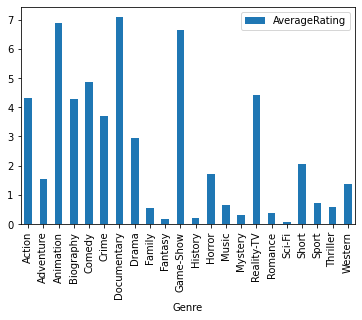

In [188]:
new_genre19 = pd.merge(r_genre19_df,total,how='inner',on ='Genre')
new_genre19['AverageRating']= new_genre19['Rating']/new_genre19['Number']
new_genre19.plot('Genre','AverageRating' , kind = 'bar')

new_genre19

### this plot shows that Documentary, Game-show and Animation received the highest average ratings

<AxesSubplot:xlabel='Genre'>

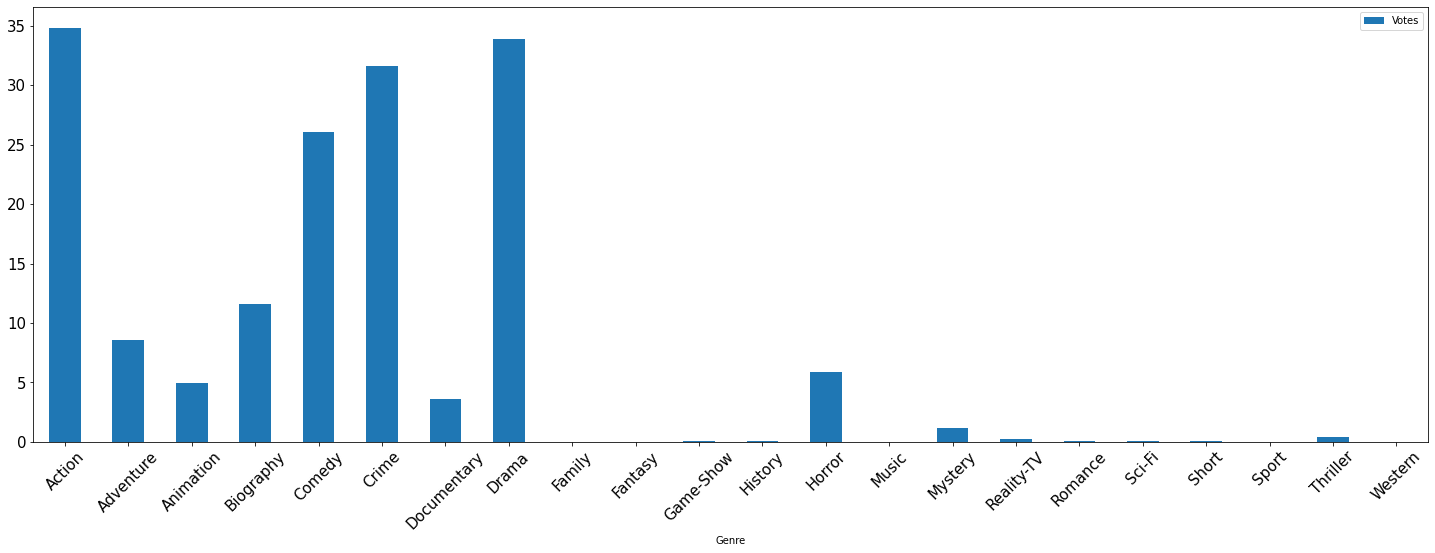

In [164]:
# Genre VS Votes Plot - 2019
new_genre19.plot('Genre', 'Votes', rot = 45, kind = 'bar', figsize = (25,8), fontsize = 15)


###  <jusitfy> The plot shows that for the year 2019, action followed by Drama was the most voted Genre. The number of votes may also be treated as an indirect indicator of the number of views of a given genre, as the data for exact number of views is not freely available.
### Keeping this in mind, one can safely say that 'Drama' was the most viewed genre of 2019

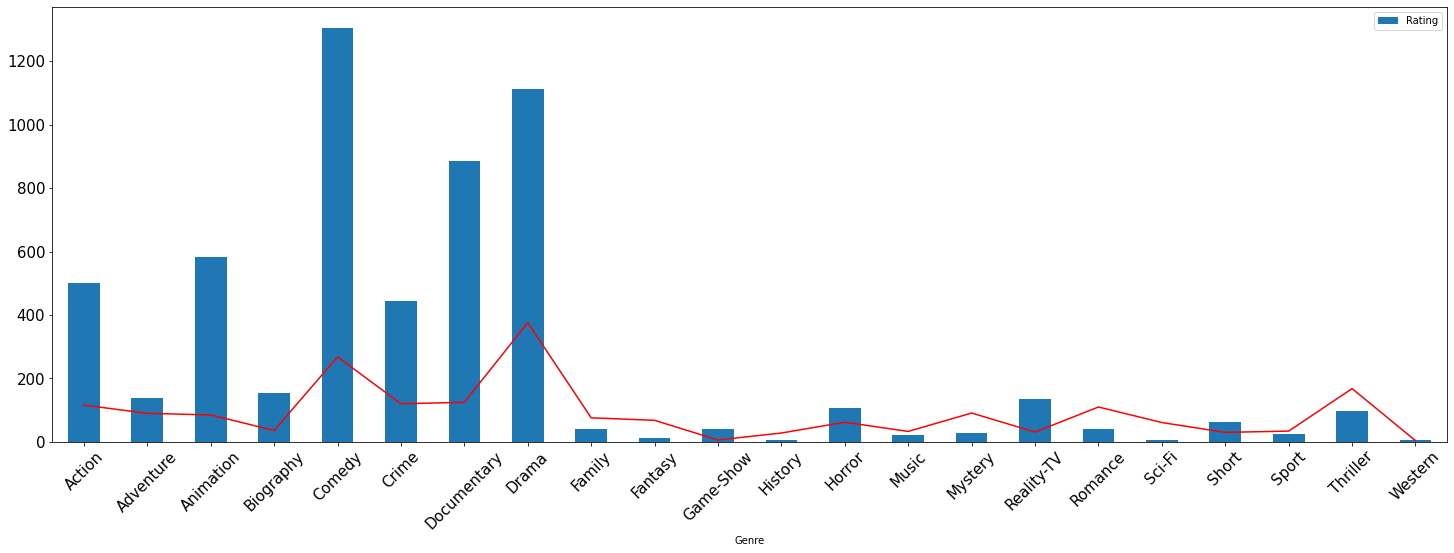

In [167]:
new_genre19.plot('Genre', 'Rating', rot = 45, kind = 'bar', figsize = (25,8), fontsize = 15)
plt.plot(new_genre19['Genre'],new_genre19['Number'], c = 'r')#line showing total number of movies in each genre

### The plot shows that for the year 2019, comedy was the highest total rated Genre. The ratings of the genre may also be treated as an indirect indicator of the number of views of a given genre, as the data for exact number of views is not freely available.
### Keeping this in mind, one can safely say that 'Comedy' was the most loved genre of 2019

r is 0.7156613640601387 and p is 0.00018060536267573972


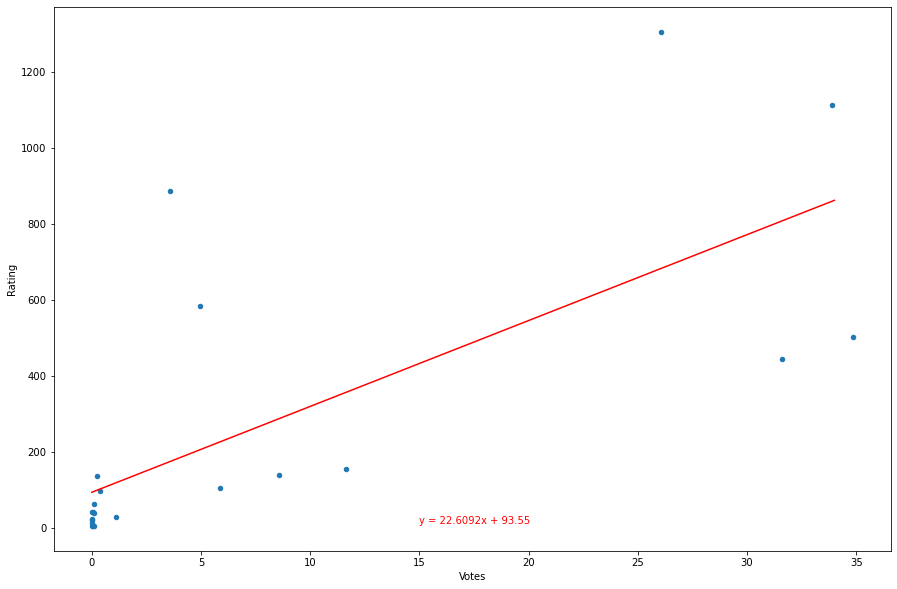

In [170]:
new_genre19.plot('Votes','Rating', kind = 'scatter', figsize = (15,10), fontsize = 10)
x = new_genre19['Votes']
y = new_genre19['Rating']
nx = 15
ny = 10
regress(x,y, nx, ny)


# 2020 Movies Database


In [171]:

movie20_df = fetch_db(movie20)


--------------------------------------
Extracting Data from OMDB
--------------------------------------
Movie: Accomplice check
Movie: Kilometers and Kilometers check
Movie: So My Grandma’s a Lesbian! check
Movie: Friendsgiving check
Movie: The Shadow of Violence  details not found
Movie: Cut Throat City check
Movie: Sightless check
Movie: Death of Me check
Movie: Double Dad check
Movie: The Magicians check
Movie: The Vanished check
Movie: The Heartbreak Club check
Movie: Last Tango in Halifax check
Movie: 100% Halal check
Movie: Pieces of a Woman check
Movie: Tony Parker: The Final... check
Movie: Korean Pork Belly Rhapsody  details not found
Movie: Asphalt Burning check
Movie: Full Out 2: You Got This! check
Movie: Running Man check
Movie: Best of Stand-Up 2020 check
Movie: Chilling Adventures of... check
Movie: Tarung Sarung check
Movie: Best Leftovers Ever! check
Movie: Equinox check
Movie: Gameboys Level-Up Edition  details not found
Movie: SanPa: Sins of the Savior  details not f

Movie: David Attenborough: A... check
Movie: Best Wishes, Warmest... check
Movie: Schitt's Creek check
Movie: A Go! Go! Cory Carson... check
Movie: Dick Johnson Is Dead check
Movie: Emily in Paris check
Movie: Òlòtūré check
Movie: Serious Men check
Movie: The Binding check
Movie: Vampires vs. the Bronx check
Movie: You've Got This check
Movie: All Because of You check
Movie: Good Morning, Verônica check
Movie: Oktoberfest: Beer & Blood check
Movie: The Book of Sun  details not found
Movie: The Outpost check
Movie: The Worst Witch check
Movie: You Cannot Hide check
Movie: American Murder: The... check
Movie: Man with a Plan check
Movie: The Boys in the Band check
Movie: The Boys in the Band... check
Movie: Wentworth check
Movie: Michelle Buteau... check
Movie: Welcome to Sudden Death check
Movie: Whose Vote Counts... check
Movie: The Good Place check
Movie: A Perfect Crime check
Movie: Mighty Little Bheem check
Movie: Sneakerheads check
Movie: The Great British... check
Movie: The Schoo

Movie: Crazy Delicious check
Movie: Nobody Knows I'm Here check
Movie: Eric Andre: Legalize... check
Movie: Roswell, New Mexico check
Movie: Kappela check
Movie: It's Okay to Not Be Okay check
Movie: Babies check
Movie: Chaman Bahaar check
Movie: Disclosure check
Movie: Feel the Beat check
Movie: Floor Is Lava check
Movie: Lost Bullet check
Movie: Most Beautiful Thing check
Movie: One-Way to Tomorrow check
Movie: Rhyme Time Town check
Movie: The Politician check
Movie: Wasp Network check
Movie: A Whisker Away check
Movie: El límite infinito check
Movie: One Take check
Movie: The Order check
Movie: Riding Faith check
Movie: Alexa & Katie check
Movie: Asura Guru check
Movie: How to Get Away with... check
Movie: Milea check
Movie: Axone check
Movie: Da 5 Bloods check
Movie: Dating Around check
Movie: F is for Family check
Movie: Frank Elstner: Just One... check
Movie: Jo Koy: In His Elements check
Movie: The Search check
Movie: The Woods check
Movie: Whispers check
Movie: Curon check
Movi

Movie: Isi & Ossi check
Movie: Taj Mahal 1989 check
Movie: Love Is Blind check
Movie: Narcos: Mexico check
Movie: To All the Boys: P.S. I... check
Movie: Captain Underpants Epic... check
Movie: ROAD TO ROMA check
Movie: Dragons: Rescue Riders check
Movie: Horse Girl check
Movie: Locke & Key check
Movie: My Holo Love check
Movie: Who Killed Malcolm X? check
Movie: Cagaster of an Insect Cage check
Movie: #cats_the_mewvie  details not found
Movie: The Pharmacist check
Movie: Uppity: The Willy T... check
Movie: Dragonheart: Vengeance check
Movie: Tom Papa: You're Doing... check
Movie: Team Kaylie check
Movie: The Silent War check
Movie: Itaewon Class check
Movie: Night on Earth: Shot in... check
Movie: 37 Seconds check
Movie: Diablero check
Movie: I AM A KILLER check
Movie: Luna Nera check
Movie: Miss Americana check
Movie: Ragnarok check
Movie: Unauthorized Living check
Movie: THE STRANGER check
Movie: What the Love! with... check
Movie: Find Yourself check
Movie: Next in Fashion check
Mo

In [172]:
revenue20_df = movie_id(movie20)

Revenue found for tmdb id 138
Revenue found for tmdb id 11868
Revenue found for tmdb id 33521
Revenue found for tmdb id 40631
Revenue found for tmdb id 86889
Revenue found for tmdb id 94161
Revenue found for tmdb id 238957
Revenue found for tmdb id 339798
Revenue found for tmdb id 515806
Revenue found for tmdb id 518293
Revenue found for tmdb id 682295
Revenue found for tmdb id 723186
Revenue found for tmdb id 223
Revenue found for tmdb id 409626
Revenue found for tmdb id 505379
Revenue found for tmdb id 527570
Revenue found for tmdb id 597384
Revenue found for tmdb id 636690
Revenue found for tmdb id 643732
Revenue found for tmdb id 339
Revenue found for tmdb id 539
Revenue found for tmdb id 11252
Revenue found for tmdb id 772321
Revenue found for tmdb id 879
Revenue found for tmdb id 2046
Revenue found for tmdb id 133194
Revenue found for tmdb id 270166
Revenue found for tmdb id 275546
Revenue found for tmdb id 328425
Revenue found for tmdb id 350739
Revenue found for tmdb id 360542


Revenue found for tmdb id 45685
Revenue found for tmdb id 248828
Revenue found for tmdb id 751267
Revenue found for tmdb id 790709
Revenue found for tmdb id 48287
Revenue found for tmdb id 50363
Revenue found for tmdb id 142931
Revenue found for tmdb id 165431
Revenue found for tmdb id 184543
Revenue found for tmdb id 479316
Revenue found for tmdb id 547883
Revenue found for tmdb id 653715
Revenue found for tmdb id 717153
Revenue found for tmdb id 51181
Revenue found for tmdb id 52282
Revenue found for tmdb id 701421
Revenue found for tmdb id 52732
Revenue found for tmdb id 433520
Revenue found for tmdb id 784548
Revenue found for tmdb id 55294
Revenue found for tmdb id 127741
Revenue found for tmdb id 270612
Revenue found for tmdb id 477492
Revenue found for tmdb id 770150
Revenue found for tmdb id 770922
Revenue found for tmdb id 783634
Revenue found for tmdb id 55674
Revenue found for tmdb id 120676
Revenue found for tmdb id 188102
Revenue found for tmdb id 191575
Revenue found for 

Revenue found for tmdb id 531625
Revenue found for tmdb id 462151
Revenue found for tmdb id 493058
Revenue found for tmdb id 549989
Revenue found for tmdb id 714611
Revenue found for tmdb id 463435
Revenue found for tmdb id 615677
Revenue found for tmdb id 743749
Revenue found for tmdb id 463940
Revenue found for tmdb id 468624
Revenue found for tmdb id 594084
Revenue found for tmdb id 645482
Revenue found for tmdb id 648631
Revenue found for tmdb id 481789
Revenue found for tmdb id 487291
Revenue found for tmdb id 493065
Revenue found for tmdb id 497582
Revenue found for tmdb id 505225
Revenue found for tmdb id 505895
Revenue found for tmdb id 514287
Revenue found for tmdb id 524840
Revenue found for tmdb id 741888
Revenue found for tmdb id 526007
Revenue found for tmdb id 526052
Revenue found for tmdb id 555132
Revenue found for tmdb id 581111
Revenue found for tmdb id 698979
Revenue found for tmdb id 699280
Revenue found for tmdb id 750037
Revenue found for tmdb id 751612
Revenue fo

In [173]:
revenue20_df

,Title,MovieID,revenue
0,Dracula,tt0021814,700000
1,Dracula,tt0051554,0
2,Dracula,tt0079073,0
3,Dracula,tt0847161,0
4,Dracula,tt0070003,0
...,...,...,...
684,A California Christmas,tt13055780,0
685,100% Halal,tt11799742,0
686,Death to 2020,tt13567480,0
687,A Trash Truck Christmas,tt13458584,0


In [268]:
#joining the revenue dataframe with the genre dataframe based on movie title and imdb ID
rev20_db = pd.merge(movie20_df,revenue20_df,how = 'inner', on = ['Title','MovieID'])
revenue_df.set_index('Title')
revenue_df.head(100)
# a small smaple of data is present which has information on revenue. But the sample size is suffiecient for representing the data
rev20_db = rev20_db[rev20_db['revenue']!=0]
print(len(rev20_db))

24


In [269]:
rev20_db

,MovieID,Title,Votes,Rating,Genre,revenue
4,tt1830643,Death of Me,586.0,6.3,"[Horror, Mystery, Thriller]",41848
26,tt8784956,Ava,28.0,5.5,"[Action, Crime, Drama, Thriller]",2987741
33,tt1911644,The Call,110478.0,6.3,"[Crime, Drama, Horror, Thriller]",68572378
34,tt6508228,Ghosts of War,387.0,3.7,"[Horror, Thriller, War]",178592
49,tt0032976,Rebecca,216.0,7.5,"[Drama, Mystery, Romance, Thriller]",6000000
51,tt1070874,The Trial of the Chicago 7,180.0,7.1,"[Drama, History, Thriller]",104048
69,tt5023260,The Last Word,1169.0,5.4,"[Comedy, Drama]",1783421
72,tt0286106,Signs,79347.0,4.5,"[Drama, Mystery, Sci-Fi, Thriller]",408247917
74,tt0097328,Family Business,130.0,5.6,"[Crime, Drama]",12195695
76,tt0864761,The Duchess,245900.0,7.9,"[Biography, Drama, History, Romance]",43306325


<AxesSubplot:xlabel='Genre'>

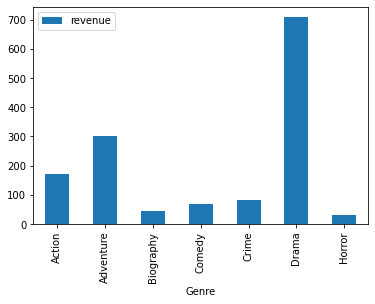

In [270]:
final20_rev_df = genre_revenue(rev20_db,genre20_df)
final20_rev_df
final20_rev_df.drop(index =(final20_rev_df.loc[final20_rev_df['revenue']==0,:]).index, inplace = True) # removing genres which did not have revenue details
final20_rev_df.plot('Genre','revenue',kind = 'bar')# revenue in millions
final20_rev

In [176]:
movie20_db = movie20_df
# cleaning up the data
movie20_db['Votes'].replace(',','', regex=True, inplace=True)
movie20_db['Rating'].replace(',','', regex=True, inplace=True)
# remove commas from votes and ratings
movie20_db['Votes'] = movie19_db['Votes'].apply(pd.to_numeric, downcast='float', errors='coerce')
movie20_db['Rating'] = movie19_db['Rating'].apply(pd.to_numeric, downcast='float', errors='coerce')
# convert to float for numeric calculation

In [177]:
movie20_db.dtypes


MovieID     object
Title       object
Votes      float64
Rating     float64
Genre       object
dtype: object

In [178]:
#Dropping rows with null value
movie20_db.dropna(inplace=True)
len(movie20_db)

813

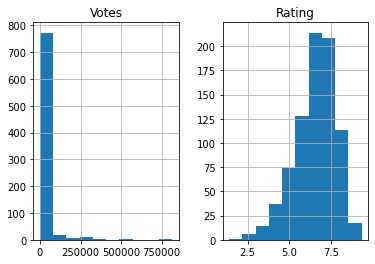

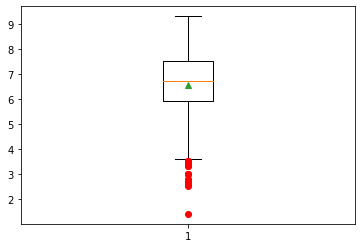

---------------------- After dropping Outliers----------------------
-----------------------Final Data Points = 796----------------------


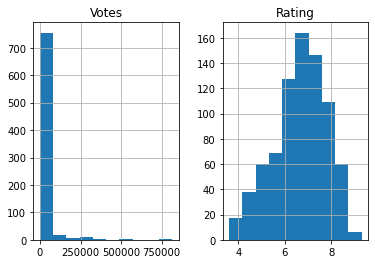

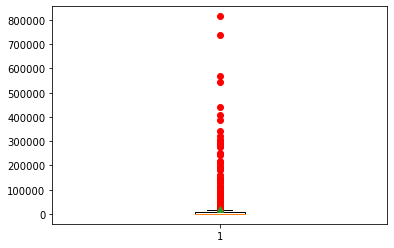

---------------------- After dropping Outliers----------------------
-----------------------Final Data Points = 691----------------------


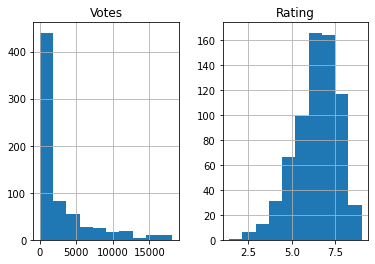

In [179]:
# understanding the Movie Ratings and Votes Data
#Shape of data
movie20_db.hist()

# Identifying and removing Outliers from Ratings
outlier(movie20_db, 'Rating')
outlier(movie20_db, 'Votes')
    
# movie ratings are now somewhat normally distributed  

In [192]:
new_genre = []
for i in movie20_db['Genre']:
    for j in i:
        new_genre.append(j.strip())
    
genre20_list = np.unique(new_genre)
genre20_list.sort()
genre20_list
genre20_df = pd.DataFrame({'Genre':genre20_list})
genre20_df #25 different genre
# row #17 list N/A as a Genre which needs to be removed
genre20_df = genre20_df.drop(index=17)
r_genre20_df = genre19_df.copy()# extra copy
genre20_df

,Genre
0,Action
1,Adventure
2,Animation
3,Biography
4,Comedy
5,Crime
6,Documentary
7,Drama
8,Family
9,Fantasy


<AxesSubplot:xlabel='Genre'>

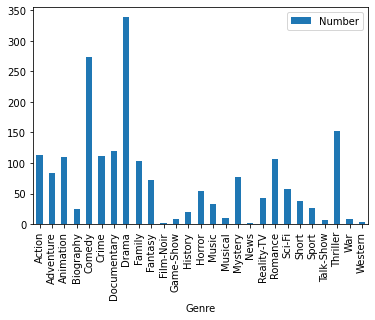

In [193]:
#identifying the number of movies in each genre
matrix = pd.get_dummies((movie20_db['Genre'].apply(pd.Series).stack()).str.strip()).sum(level = 0)
matrix.drop(columns = 'N/A', inplace = True)
total = pd.DataFrame(matrix.sum())
total['Genre']= total.index
total.set_index(np.arange(27))
total.rename(columns = {0: 'Number'}, inplace = True)
total.plot('Genre','Number', kind = 'bar')

In [202]:
rating_votes(movie20_db, genre20_df)
r_genre20_df = genre20_df

In [203]:
#dropping empty genre Musical, Mystery, News, Sci-Fi, Sport, War, Western
genre20_df.drop(index=genre20_df.loc[genre20_df['Votes'] ==0,:].index, inplace = True)


<AxesSubplot:xlabel='Genre'>

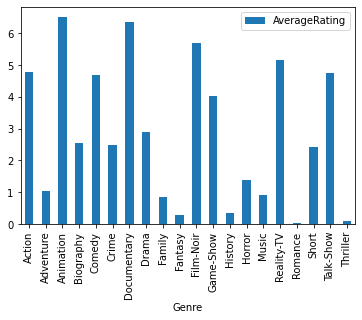

In [205]:
new_genre20 = pd.merge(r_genre20_df,total,how='inner',on ='Genre')
new_genre20['AverageRating']= new_genre20['Rating']/new_genre20['Number']
new_genre20.plot('Genre','AverageRating' , kind = 'bar')



<AxesSubplot:xlabel='Genre'>

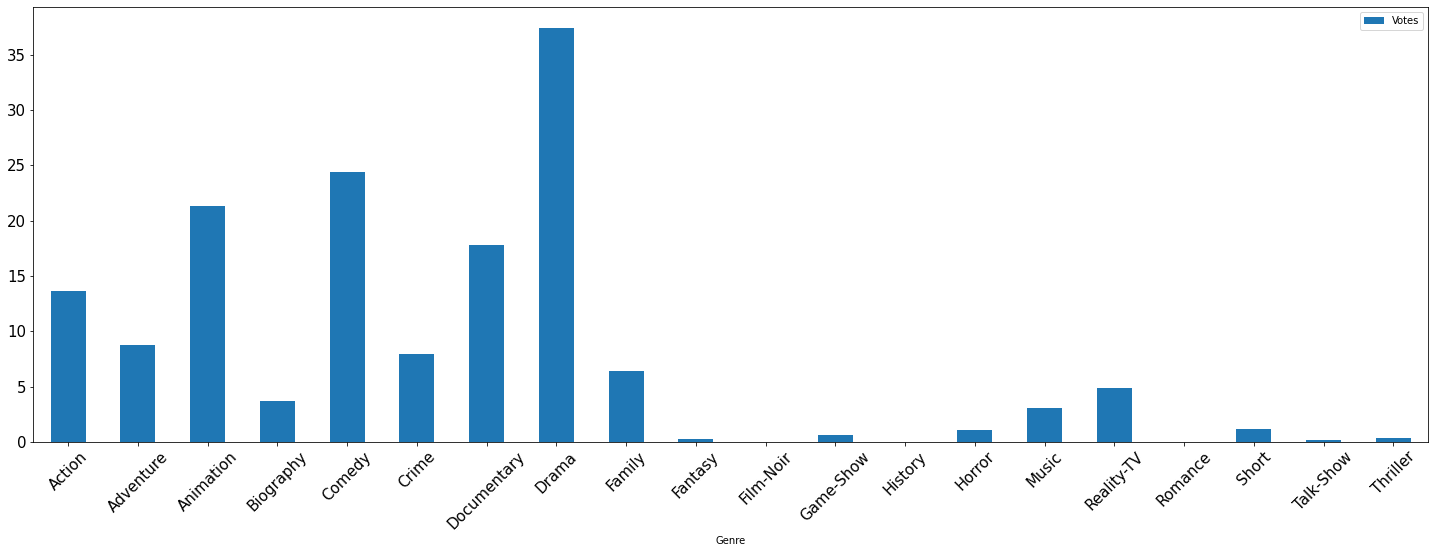

In [206]:
# Genre VS Votes Plot - 2020
new_genre20.plot('Genre', 'Votes', rot = 45, kind = 'bar', figsize = (25,8), fontsize = 15)

<AxesSubplot:xlabel='Genre'>

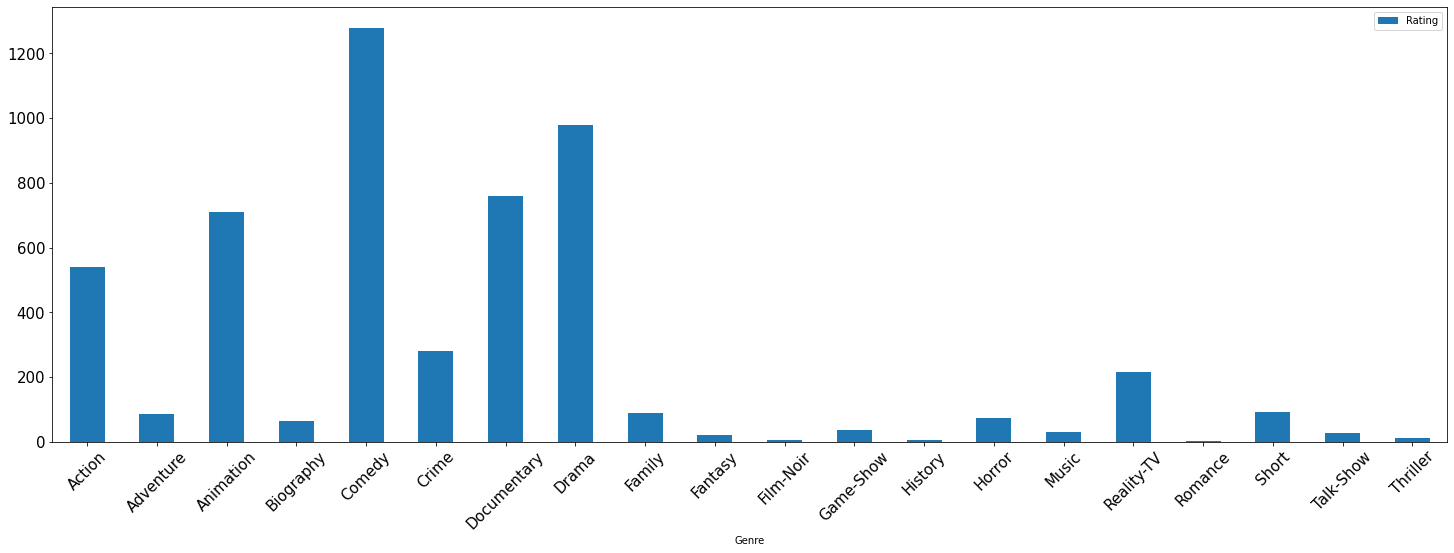

In [207]:
# Genre VS Rating Plot - 2020
new_genre20.plot('Genre', 'Rating', rot = 45, kind = 'bar', figsize = (25,8), fontsize = 15)

r is 0.9240983122146261 and p is 6.014781657188787e-09


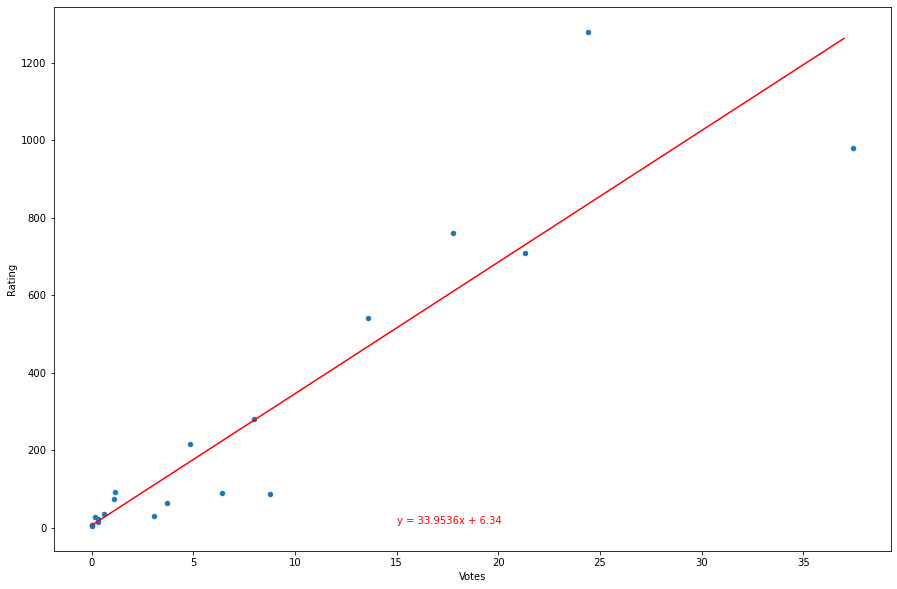

In [213]:

new_genre20.plot('Votes','Rating', kind = 'scatter', figsize = (15,10), fontsize = 10)
x = new_genre20['Votes']
y = new_genre20['Rating']
nx = 15
ny = 10
regress(x,y, nx, ny)

In [71]:
# t test means of ratings  2019 & 2020 

In [ ]:
# anova between the genres revenue , 

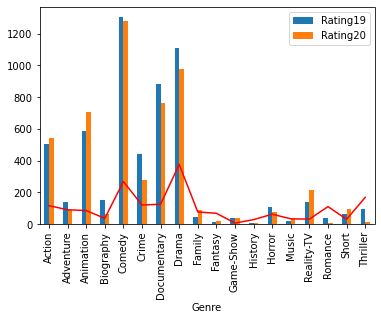

In [246]:
# Comparison graphs
output = pd.merge(new_genre19,new_genre20, how = 'outer', on = ['Genre'])
output.dropna(inplace = True)
r_output = pd.DataFrame({'Genre':output['Genre'],'Rating19': output['Rating_x'],'Rating20': output['Rating_y']})
r_output.plot(x = 'Genre', kind = 'bar')

plt.plot(output['Genre'], output['Number_x'], c = 'r') # line showing the total number of movies in that Genre - Comedy is the clear winner in terms of Ratings

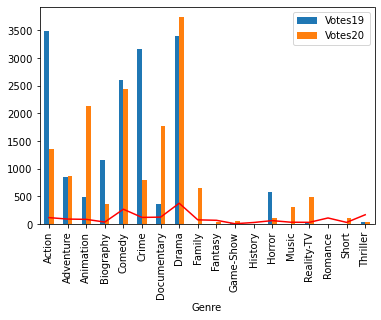

In [255]:
v_output = pd.DataFrame({'Genre':output['Genre'],'Votes19': output['Votes_x']*100,'Votes20': output['Votes_y']*100})
v_output.plot(x = 'Genre', kind = 'bar')
plt.plot(output['Genre'], output['Number_x'], c = 'r') # line showing the total number of movies in that Genre - Comedy is the clear winner in terms of Ratings

<AxesSubplot:xlabel='Genre'>

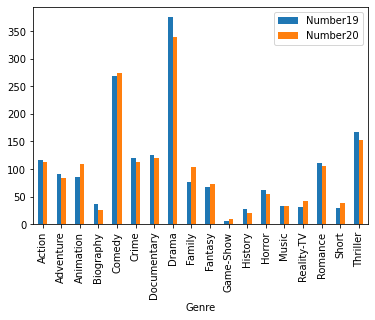

In [252]:

n_output = pd.DataFrame({'Genre':output['Genre'],'Number19': output['Number_x'],'Number20': output['Number_y']})

n_output.plot(x = 'Genre', kind = 'bar')
# # r_output = pd.DataFrame({'Genre':output['Genre'],'Rating19': output['Rating_x'],'Rating20': output['Rating_y']})
# # r_output.plot(x = 'Genre', kind = 'bar')


# plt.plot(output['Genre'], output['Number_x'], c = 'r') # line showing the total number of movies in that Genre - Comedy is the clear winner in terms of Ratings

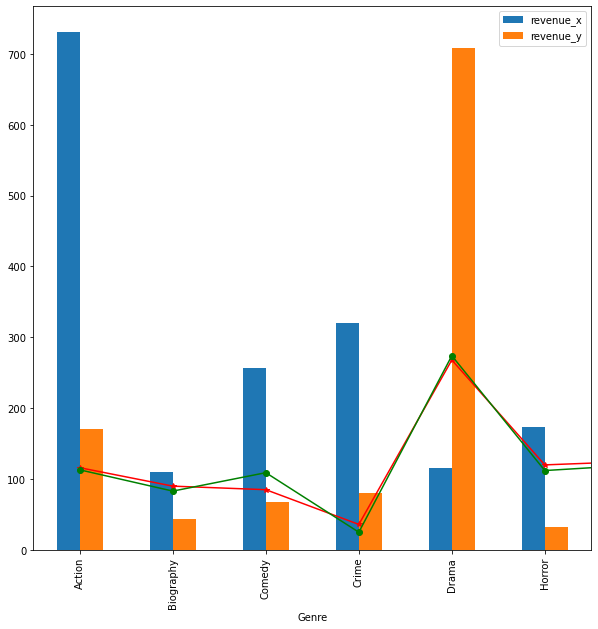

In [295]:
rev_out = pd.merge(final19_rev_df, final20_rev_df , how = 'inner', on='Genre')
rev_out.drop(columns = ['Votes','Rating'],axis = 1, inplace = True)
rev_out.plot(x = 'Genre', kind = 'bar', figsize = (10,10))
plt.plot(output['Genre'], output['Number_x'], c = 'r', marker = '*') # line showing the total number of movies in that Genre - Comedy is the clear winner in terms of Ratings
plt.plot(output['Genre'], output['Number_y'], c = 'g',marker = 'o') # line showing the total number of movies in that Genre - Comedy is the clear winner in terms of Ratings

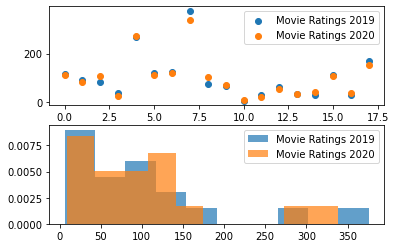

In [309]:
    population1 = output['Number_x']
    population2 = output['Number_y']
        # Scatter Plot of Data
    plt.subplot(2, 1, 1)
    plt.scatter(range(len(population1)), population1, label="Movie Ratings 2019")
    plt.scatter(range(len(population2)), population2, label="Movie Ratings 2020")
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.hist(population1, 10, density=True, alpha=0.7, label="Movie Ratings 2019")
    plt.hist(population2, 10, density=True, alpha=0.7, label="Movie Ratings 2020")
#     plt.axvline(population1.mean(), color='k', linestyle='dashed', linewidth=1)
#     plt.axvline(population2.mean(), color='k', linestyle='dashed', linewidth=1)
    plt.legend()  

In [310]:
st.ttest_ind(population1, population2, equal_var=False)

Ttest_indResult(statistic=0.04283969921803736, pvalue=0.9660812353298834)

In [ ]:
# the p-value >0.05 hence the rating data for movies we accept the null hypothesis. There is no difference berween the rating trends of 2019 VS 2020


In [305]:
output

,Genre,Votes_x,Rating_x,Number_x,AverageRating_x,Votes_y,Rating_y,Number_y,AverageRating_y
0,Action,34.83879,501.600001,116.0,4.324138,13.60444,540.400003,113.0,4.782301
1,Adventure,8.57826,137.800000,90.0,1.531111,8.77348,86.799999,83.0,1.045783
2,Animation,4.95420,583.599998,85.0,6.865882,21.29637,709.299997,109.0,6.507339
3,Biography,11.64008,153.600000,36.0,4.266667,3.71229,63.900001,25.0,2.556000
4,Comedy,26.07779,1305.700000,268.0,4.872015,24.41183,1279.400000,274.0,4.669343
5,Crime,31.61791,444.199998,120.0,3.701667,7.96283,279.800000,112.0,2.498214
6,Documentary,3.58488,885.900004,125.0,7.087200,17.75502,760.400000,120.0,6.336667
7,Drama,33.91198,1113.000000,376.0,2.960106,37.42649,979.399999,339.0,2.889086
8,Family,0.03083,42.100000,76.0,0.553947,6.42909,88.700001,103.0,0.861165
9,Fantasy,0.01619,12.300000,68.0,0.180882,0.29918,21.400000,72.0,0.297222
